In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
customers = pd.read_excel("C:/Users/Ravali/Downloads/customers.xlsx")
transactions = pd.read_excel("C:/Users/Ravali/Downloads/transactions.xlsx")

In [9]:
data = pd.merge(transactions, customers, on="customer_id", how="inner")

In [11]:
import datetime as dt
snapshot_date = data['transaction_date'].max() + pd.Timedelta(days=1)

customer_features = data.groupby('customer_id').agg({
    'transaction_date': [lambda x: (snapshot_date - x.max()).days,  # Recency
                         'count'],                                   # Frequency
    'purchase_amount': 'sum'                                         # Monetary
}).reset_index()

customer_features.columns = ['customer_id', 'recency', 'frequency', 'monetary']
customer_features['aov'] = customer_features['monetary'] / customer_features['frequency']

In [13]:
from sklearn.model_selection import train_test_split

X = customer_features[['recency', 'frequency', 'aov']]
y = customer_features['monetary']  # or future LTV target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 621.2 kB/s eta 0:04:01
   ---------------------------------------- 0.5/150.0 MB 621.2 kB/s eta 0:04:01
   ---------------------------------------- 0.8/150.0 MB 633.2 kB/s eta 0:03:56
   ---------------------------------------- 0.8/150.0 MB 633.2 kB/s eta 0:03:56
   ---------------------------------------- 1.0/150.0 MB 637.3 kB/s eta 0:03:54
   ---------------------------------------- 1.3/150.0 MB 762.6 kB/s eta 0:03:15
   ---------------------------------------- 1.3/150.0 MB 762.6 kB/s eta 0:03:15
   ---------------------------------------- 1.8/150.0 MB 831.8 kB/s eta 0:02:59
    -

In [18]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
y_pred = model.predict(X_test)


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 201.02130126953125
RMSE: 201.02130126953125


In [29]:
# Create the qcut without labels to get the actual number of bins
bins = pd.qcut(customer_features['predicted_ltv'], q=4, duplicates='drop')

# Get the actual number of unique bins
num_bins = bins.cat.categories.size

# Define appropriate number of labels
label_list = ['Low', 'Medium', 'High', 'Very High'][:num_bins]

# Now re-run with the correct number of labels
customer_features['ltv_segment'] = pd.qcut(
    customer_features['predicted_ltv'],
    q=num_bins,
    labels=label_list,
    duplicates='drop'
)


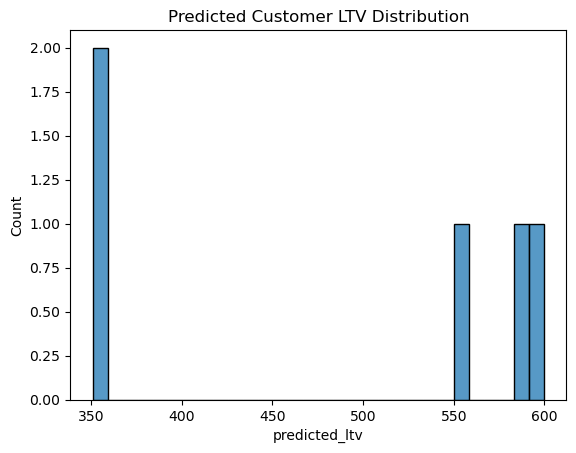

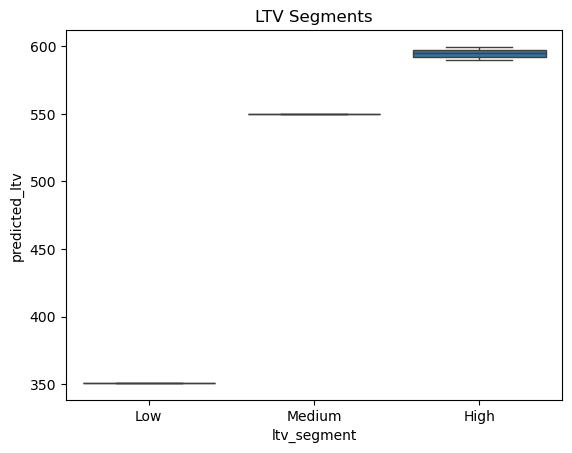

In [31]:
sns.histplot(customer_features['predicted_ltv'], bins=30)
plt.title('Predicted Customer LTV Distribution')
plt.show()

sns.boxplot(x='ltv_segment', y='predicted_ltv', data=customer_features)
plt.title('LTV Segments')
plt.show()


In [33]:
import joblib
joblib.dump(model, 'ltv_model.pkl')


['ltv_model.pkl']

In [35]:
customer_features[['customer_id', 'predicted_ltv', 'ltv_segment']].to_csv("ltv_predictions.csv", index=False)
